In [2]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from gensim.models import FastText
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import swifter
import pickle


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/training_cleaned.csv")
data["tweet"] = data["tweet"].swifter.apply(lambda x : str(x))
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)


Pandas Apply:   0%|          | 0/1600000 [00:00<?, ?it/s]

In [6]:
documents = [str(tweet).split() for tweet in train_data["tweet"]] 

fasttext_model = FastText(documents, size=100, window=5, min_count=5, workers=8, sg=1)

In [7]:
fasttext_model.most_similar("twitter")

<ipython-input-7-d5015ced9e11>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  fasttext_model.most_similar("twitter")


[('twitteer', 0.9281846284866333),
 ('twittet', 0.9167379140853882),
 ('twitte', 0.9106214046478271),
 ('twitterati', 0.9008215665817261),
 ('twitterjail', 0.8996176719665527),
 ('twittermail', 0.8964031338691711),
 ('loudtwitter', 0.8959870338439941),
 ('twittedfon', 0.8959791660308838),
 ('twitteroos', 0.8952099084854126),
 ('twitterz', 0.8904939889907837)]

In [8]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["tweet"])

word_count = len(tokenizer.word_index) + 1
print(f"Total words: {word_count}")

Total words: 211123
CPU times: user 15.2 s, sys: 167 ms, total: 15.4 s
Wall time: 16.1 s


In [9]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data["tweet"]), maxlen=100)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data["tweet"]), maxlen=100)

## Label Encoder

In [10]:


encoder = LabelEncoder()
encoder.fit(train_data["sentiment"].tolist())

y_train = encoder.transform(train_data["sentiment"].tolist())
y_test = encoder.transform(test_data["sentiment"].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [11]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)


x_train (1280000, 100)
y_train (1280000, 1)

x_test (320000, 100)
y_test (320000, 1)


## Embedding

In [ ]:
embedding_matrix = np.zeros((word_count, 100))
for word, i in tokenizer.word_index.items():
  if word in fasttext_model.wv:
    embedding_matrix[i] = fasttext_model.wv[word]

print(embedding_matrix.shape)

(211123, 100)


In [ ]:
embedding_layer = Embedding(word_count, 100, weights=[embedding_matrix], input_length=100, trainable=False)

In [ ]:
%%time
sequence_input = Input(shape=(100,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
k_model = tf.keras.Model(sequence_input, outputs)


CPU times: user 407 ms, sys: 2.1 ms, total: 409 ms
Wall time: 1.14 s


In [ ]:
k_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


In [ ]:
history = k_model.fit(x_train, y_train, batch_size=1000, epochs=20, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/20
1280/1280 [==============================] - 497s 380ms/step - loss: 0.5080 - accuracy: 0.7487 - val_loss: 0.4690 - val_accuracy: 0.7763 - lr: 0.0100
Epoch 2/20
1280/1280 [==============================] - 482s 377ms/step - loss: 0.4882 - accuracy: 0.7625 - val_loss: 0.4638 - val_accuracy: 0.7766 - lr: 0.0100
Epoch 3/20
1280/1280 [==============================] - 481s 375ms/step - loss: 0.4830 - accuracy: 0.7656 - val_loss: 0.4623 - val_accuracy: 0.7786 - lr: 0.0100
Epoch 4/20
1280/1280 [==============================] - 476s 372ms/step - loss: 0.4810 - accuracy: 0.7670 - val_loss: 0.4590 - val_accuracy: 0.7792 - lr: 0.0100
Epoch 5/20
1280/1280 [==============================] - 509s 398ms/step - loss: 0.4794 - accuracy: 0.7680 - val_loss: 0.4608 - val_accuracy: 0.7801 - lr: 0.0100
Epoch 6/20
1280/1280 [==============================] - 481s 376ms/step - loss: 0.4783 - accuracy: 0.7688 - val_loss: 0.4582 - val_accuracy: 0.7802 - lr: 0.0100
Epoch 7/20
1280/1280 [============

(2,)


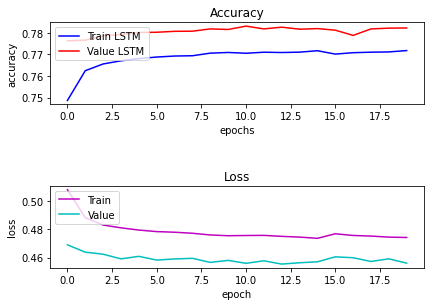

In [ ]:
s, subplots = plt.subplots(2, 1)
plt.tight_layout()

s.subplots_adjust(hspace=1)

print(subplots.shape)
subplots[0].plot(history.history['accuracy'], c='b')
subplots[0].plot(history.history['val_accuracy'], c='r')
subplots[0].set_title('Accuracy')
subplots[0].set_ylabel('accuracy')
subplots[0].set_xlabel('epochs')
subplots[0].legend(['Train LSTM ', 'Value LSTM'], loc='upper left')

subplots[1].plot(history.history['loss'], c='m')
subplots[1].plot(history.history['val_loss'], c='c')
subplots[1].set_title('Loss')
subplots[1].set_ylabel('loss')
subplots[1].set_xlabel('epoch')
subplots[1].legend(['Train', 'Value'], loc='upper left')



In [ ]:
k_model.save("/content/drive/MyDrive/Colab Notebooks/model/training_cleaned.h5")
fasttext_model.save("/content/drive/MyDrive/Colab Notebooks/model/fasttext_model.pkl")
pickle.dump(tokenizer, open("/content/drive/MyDrive/Colab Notebooks/model/tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("/content/drive/MyDrive/Colab Notebooks/model/encoder.pkl", "wb"), protocol=0)

In [12]:
k_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model/training_cleaned.h5')
tokenizer = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/model/tokenizer.pkl", 'rb'))

In [22]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = "Neutral"
        if score <= 0.5:
            label = "Negative"
        elif score >= 0.5:
            label = "Positive"

        return label
    else:
        return "Negative" if score < 0.5 else "Positive"


In [23]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
    # Predict
    score = k_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [24]:
print(predict("Crying and Laughing"))
print(predict("It's raining"))
print(predict("I love Pizza"))
print(predict("I have too many things to do"))

1/1 [==============================] - 0s 60ms/step
{'label': 'Positive', 'score': 0.8807203769683838, 'elapsed_time': 0.09399533271789551}
1/1 [==============================] - 0s 56ms/step
{'label': 'Negative', 'score': 0.09972522407770157, 'elapsed_time': 0.09250593185424805}
1/1 [==============================] - 0s 58ms/step
{'label': 'Positive', 'score': 0.9624636769294739, 'elapsed_time': 0.09206700325012207}
1/1 [==============================] - 0s 63ms/step
{'label': 'Negative', 'score': 0.30841368436813354, 'elapsed_time': 0.09634280204772949}


In [25]:
%%time
y_pred_1d = []
y_test_1d = list(test_data["sentiment"])
scores = k_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


40/40 [==============================] - 6s 152ms/step
CPU times: user 5.45 s, sys: 1.55 s, total: 7 s
Wall time: 10.7 s


In [26]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    try:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title, fontsize=30)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
      plt.yticks(tick_marks, classes, fontsize=22)

      fmt = '.2f'
      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.ylabel('True label', fontsize=25)
      plt.xlabel('Predicted label', fontsize=25)
    except Exception as e:
      print(e)

['Negative', 'Negative', 'Negative', 'Negative', 'Negative']
['Positive', 'Positive', 'Negative', 'Negative', 'Negative']


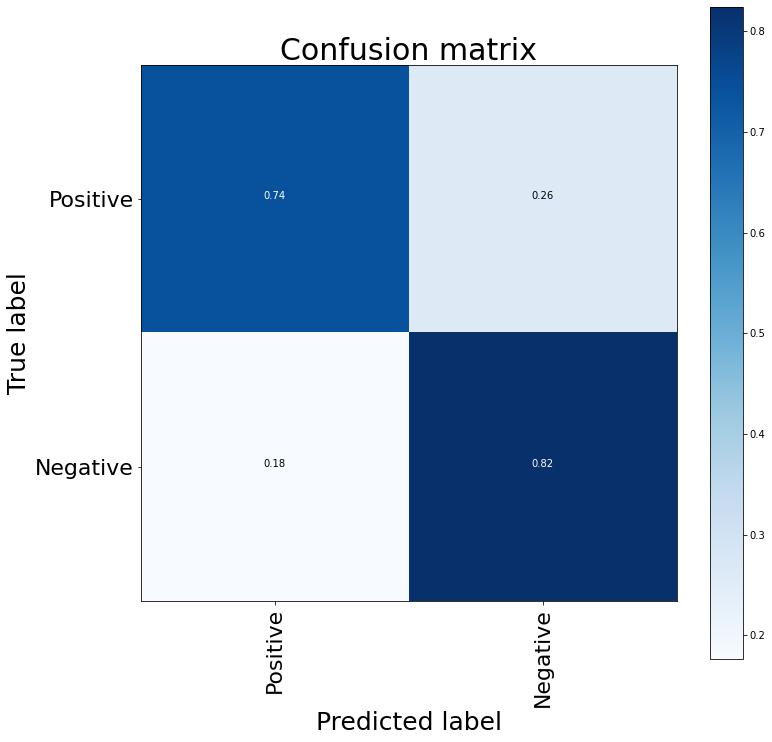

CPU times: user 1.13 s, sys: 12 ms, total: 1.14 s
Wall time: 1.13 s


In [27]:
%%time

print(y_test_1d[:5])
print(y_pred_1d[:5])
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=train_data["sentiment"].unique(), title="Confusion matrix")
plt.show()



In [28]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.81      0.74      0.77    160156
    Positive       0.76      0.82      0.79    159844

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

